<a href="https://colab.research.google.com/github/karlijnbok/stylegan/blob/master/ExploringTheLatentSpaceOfStyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the Latent Space of StyleGAN

<!-- Looking into the representation of identity, gender and emotion in the latent space of styleGAN -->

---

Bachelor's Thesis in Artificial Intelligence \\
Radboud University, Nijmegen

By Karlijn Bok, S4804821

## Data Collection

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/'My Drive'/stylegan

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/stylegan


In [2]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

1.15.0


### Preprocess Input

In [0]:
# Aligns all images in the 'original' folder
# Aligned images are stored in 'aligned' folder
!python align_images.py 'original/' 'aligned/'

Using TensorFlow backend.


### Finding Representations in Latent Space


In [0]:
# Using styleGAN trained on FFHQ
# Encoded images are stored in 'enc_ffhq'
!python encode_images_ffhq.py

In [0]:
# Using styleGAN trained on CelebA-HQ
# Encoded images are stored in 'enc_clba'
!python encode_images_clba.py

## Data Processing


> Concatenating all encoded / latent vectors `(18, 512)` into one matrix `(312, 18*512)`

In [0]:
import os
import numpy as np

Concatenate all vectors in `enc_ffhq` and `enc_clba` into one matrix

In [0]:
assert len(os.listdir('enc_ffhq') ) == 312
identity_space_ffhq = np.zeros((312, 18*512)) # (312, 9216)

i = 0
for enc in os.listdir('enc_ffhq'):
  array = np.load('enc_ffhq/' + enc)  
  identity_space_ffhq[i] = np.concatenate(array, axis=0)
  i+=1

np.save('identity_space_ffhq.npy', identity_space_ffhq)

In [0]:
assert len(os.listdir('enc_clba') ) == 312
identity_space_clba = np.zeros((312, 18*512)) # (312, 9216)

i = 0
for enc in os.listdir('enc_clba'):
  array = np.load('enc_clba/' + enc)  
  identity_space_clba[i] = np.concatenate(array, axis=0)
  i+=1

np.save('identity_space_clba.npy', identity_space_clba)

## Imports, constants, functions

Imports

In [0]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import MDS, TSNE
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, norm

Constants etc.

In [0]:
datapoints = range(312)

# Identity
identities      = range(39)
identity_labels = range(1, 40)
identity_cols   = ['lightcoral', 'red', 'darkred', 'mistyrose', 'orangered', 'sienna', 
                   'saddlebrown', 'chocolate', 'sandybrown', 'darkorange', 'orange', 
                   'goldenrod', 'gold', 'lemonchiffon', 'yellow', 'olivedrab', 
                   'yellowgreen', 'greenyellow', 'lightgreen', 'green', 'lime', 
                   'aquamarine', 'turquoise', 'darkslategray', 'cyan', 'deepskyblue', 
                   'steelblue', 'royalblue', 'navy', 'blue', 'blueviolet', 'indigo', 
                   'plum', 'purple', 'magenta', 'deeppink', 'pink', 'k', 'darkslateblue']
identity_ticks  = [4 + 8*i for i in identities] 
identity_lines  = [8*i for i in range(1,39)] 

# Gender
female_index  = [0, 1, 3, 6, 9, 10, 12, 13, 14, 17, 21, 22, 25, 26, 29, 34, 35, 36, 37]
male_index    = [2, 4, 5, 7, 8, 11, 15, 16, 18, 19, 20, 23, 24, 27, 28, 30, 31, 32, 33, 38] 
gender_labels = ['Female', 'Male']
gender_cols   = ['tab:pink', 'tab:blue']
gender_ticks  = [76, 232]
gender_lines  = [152]

# Emotion
emotions       = range(8)
emotion_labels = ['Angry', 'Contemptuous', 'Disgusted', 'Fearful', 'Happy', 
                'Neutral', 'Sad', 'Surprised']
emotion_labels_short = [l[:3] for l in emotion_labels]
emotion_cols   = ['tab:red', 'tab:purple', 'tab:green', 'tab:olive', 'tab:pink', 
                'tab:gray' , 'tab:blue', 'tab:orange']
emotion_ticks  = [19 + 39*i for i in emotions]
emotion_lines  = [39*i for i in range(1,8)]

In [0]:
# Dimensionality Reduction
mds  = MDS(n_components=2, dissimilarity='precomputed')
tsne = TSNE(n_components=2, metric='precomputed')

Functions

In [0]:
def scatter_identity( ax, out ):
  x, y = out[:, 0], out[:, 1]
  for i in identities:
    j = i*8
    ax.scatter(x[j:j+8], y[j:j+8], c=identity_cols[i], label=identity_labels[i])
    
def scatter_gender( ax, out ):
  x, y = out[:, 0], out[:, 1]
  ax.scatter(x[0:152], y[0:152], c=gender_cols[0], label=gender_labels[0], marker='o')
  ax.scatter(x[152:312], y[152:312], c=gender_cols[1], label=gender_labels[1], marker='x')

def scatter_emotion( ax, out ):
  x, y = out[:, 0], out[:, 1]
  for i in emotions:
    j = i*39
    ax.scatter(x[j:j+39] , y[j:j+39], c=emotion_cols[i], label=emotion_labels[i])

In [0]:
def add_ticks_labels_lines( ax, ticks, labels, lines ):
  ax.set_xticks(ticks)
  ax.set_xticklabels(labels)
  ax.set_yticks(ticks)
  ax.set_yticklabels(labels)
  ax.vlines(lines, 0, 311)
  ax.hlines(lines, 0, 311)

Functions for significance testing

In [0]:
# Take right top half of rdm (excluding diagonal) and turn into vector
def make_significance_vector( rdm ):
  n = rdm.shape[0]
  l = n-1
  vector_length = int( (np.square(n)-n)/2 )
  vector = np.zeros(vector_length)
  start, end = 0, l
  # Loop through rows
  for i in range(l):
    length = l - i 
    vector[start:end] = rdm[i][-length:]
    start = end
    end += length-1
  return vector

# Shuffle hypothesis rdm randomly
def shuffle_rdm( rdm ):
  n = rdm.shape[0]
  idx = np.random.permutation(n)
  new_rdm = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      if(j > i):
        break
      else:
        if(i == j):
          new_rdm[i][j] = 0
        if(j < i):
          x = rdm[idx[i]][idx[j]]
          new_rdm[i][j] = x
          new_rdm[j][i] = x
  return new_rdm

def get_random_rhos( hyp_vector, rdm, n ):
  rhos = list()
  for i in range(n):
    vector = make_significance_vector(shuffle_rdm(rdm))
    rho, pval = spearmanr(hyp_vector, vector)
    rhos.append(rho)
  return rhos

## Hypotheses

In [0]:
# Make hypothesis RDMs
hyp_rdm_identity = np.ones((312, 312))
for i in range(0, 312, 8):
  hyp_rdm_identity[i:i+8, i:i+8] = np.zeros((8,8))

hyp_rdm_gender = np.ones((312, 312))
hyp_rdm_gender[0:152, 0:152]      = np.zeros((152,152))
hyp_rdm_gender[152:312, 152:312] = np.zeros((160,160))

hyp_rdm_emotion = np.ones((312, 312))
for i in range(0, 312, 39):
  hyp_rdm_emotion[i:i+39, i:i+39] = np.zeros((39,39))

In [0]:
# Make hypothesis vectors for significance testing
hyp_vector_identity = make_significance_vector(hyp_rdm_identity)
hyp_vector_gender   = make_significance_vector(hyp_rdm_gender)
hyp_vector_emotion  = make_significance_vector(hyp_rdm_emotion)

Plot Hypothesis RDMs

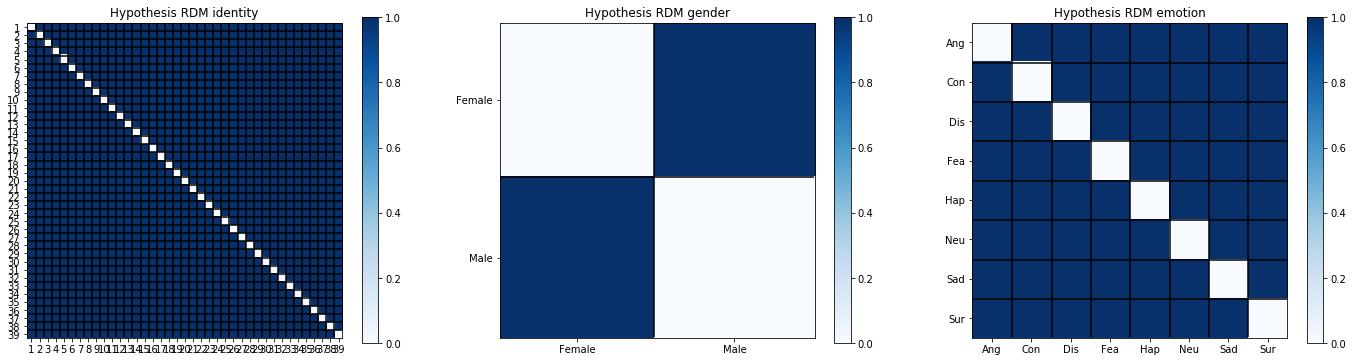

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
# fig.suptitle( 'Hypothesis RDMs' )

# Hypothesis RDM sorted on identity 
im1 = ax1.imshow(hyp_rdm_identity, cmap='Blues')
ax1.set_title('Hypothesis RDM identity')
add_ticks_labels_lines(ax1, identity_ticks, identity_labels, identity_lines)
fig.colorbar(im1, ax=ax1)

# Hypothesis RDM sorted on gender
im2 = ax2.imshow(hyp_rdm_gender, cmap='Blues')
ax2.set_title('Hypothesis RDM gender')
add_ticks_labels_lines(ax2, gender_ticks, gender_labels, gender_lines)
fig.colorbar(im2, ax=ax2)

# Hypothesis RDM sorted on emotion
im3 = ax3.imshow(hyp_rdm_emotion, cmap='Blues')
ax3.set_title('Hypothesis RDM emotion')
add_ticks_labels_lines(ax3, emotion_ticks, emotion_labels_short, emotion_lines)
fig.colorbar(im3, ax=ax3)

plt.show()

## Analysis

> Sort Spaces

Spaces sorted on identity `(1 - 39)`


In [0]:
# Since the original results were sorted for identity already, this space does not need to be sorted
identity_space_ffhq = np.load('identity_space_ffhq.npy')
identity_space_clba = np.load('identity_space_clba.npy')

Spaces sorted on gender `(Female, Male)`

In [0]:
gender_space_ffhq = np.zeros((312, 18*512)) # (312, 9216)
for i in range(19): # Add females
  for j in range(8):
    gender_space_ffhq[8*i + j] = identity_space_ffhq[8*female_index[i] + j]  
for i in range(20): # Add males
  for j in range(8):
    gender_space_ffhq[152 + 8*i + j] = identity_space_ffhq[8*male_index[i] + j]


gender_space_clba = np.zeros((312, 18*512)) # (312, 9216)
for i in range(19): # Add females
  for j in range(8):
    gender_space_clba[8*i + j] = identity_space_clba[8*female_index[i] + j]    
for i in range(20): # Add males
  for j in range(8):
    gender_space_clba[152 + 8*i + j] = identity_space_clba[8*male_index[i] + j]

Space sorted on emotion `(Angry, Comtemptuous, Disgusted, Fearful, Happy, Neutral, Sad, Surprised)`

In [0]:
emotion_space_ffhq = np.zeros((312, 18*512)) # (312, 9216)
count = 0
for i in range(8):
  for j in range(39):
    emotion_space_ffhq[count] = gender_space_ffhq[i + 8*j]
    count+=1

emotion_space_clba = np.zeros((312, 18*512)) # (312, 9216)
count = 0
for i in range(8):
  for j in range(39):
    emotion_space_clba[count] = gender_space_clba[i + 8*j]
    count+=1

### Identity

In [0]:
# Make RDMs using cosine distance
rdm_identity_ffhq = squareform( pdist(identity_space_ffhq, 'cosine') )
rdm_identity_clba = squareform( pdist(identity_space_clba, 'cosine') )

Visualisation

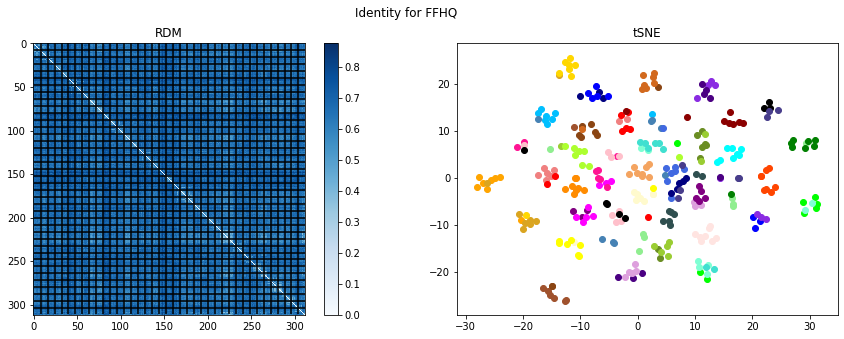

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Identity for FFHQ')

im = ax1.imshow(rdm_identity_ffhq, cmap='Blues')
ax1.set_title('RDM')
fig.colorbar(im, ax=ax1)
# add_ticks_labels_lines(ax1, identity_ticks, identity_labels, identity_lines)
ax1.vlines(identity_lines, 0, 311)
ax1.hlines(identity_lines, 0, 311)

ax2.set_title('tSNE')
scatter_identity(ax2, tsne.fit_transform(rdm_identity_ffhq))
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

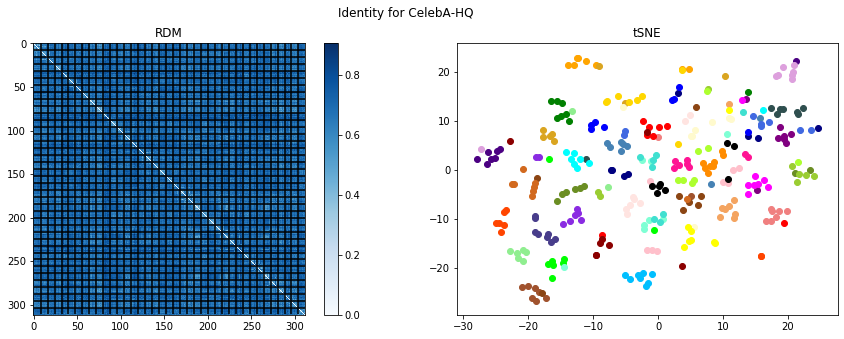

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Identity for CelebA-HQ')

im = ax1.imshow(rdm_identity_clba, cmap='Blues')
ax1.set_title('RDM')
fig.colorbar(im, ax=ax1)
# add_ticks_labels_lines(ax1, identity_ticks, identity_labels, identity_lines)
ax1.vlines(identity_lines, 0, 311)
ax1.hlines(identity_lines, 0, 311)

ax2.set_title('tSNE')
scatter_identity(ax2, tsne.fit_transform(rdm_identity_clba))
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Significance testing

If (rho > 95th percentile) of all random rhos, it is significant

In [0]:
# Collect random rho values by shuffeling one of the rdms while keeping the other unchanged

# rhos_identity_ffhq = get_random_rhos( hyp_vector_identity, rdm_identity_ffhq, 1000 )
# np.save('rhos/rhos_identity_ffhq.npy', rhos_identity_ffhq)

# rhos_identity_clba = get_random_rhos( hyp_vector_identity, rdm_identity_clba, 1000 )
# np.save('rhos/rhos_identity_clba.npy', rhos_identity_clba)

In [0]:
# Get rho values
rho_identity_ffhq, pval = spearmanr(hyp_vector_identity, make_significance_vector(rdm_identity_ffhq))
rho_identity_clba, pval = spearmanr(hyp_vector_identity, make_significance_vector(rdm_identity_clba))

# Get random rho values
rhos_identity_ffhq = np.load('rhos/rhos_identity_ffhq.npy')
rhos_identity_clba = np.load('rhos/rhos_identity_clba.npy')
# Get 95th percentile
perc_identity_ffhq = np.percentile(rhos_identity_ffhq, 95)
perc_identity_clba = np.percentile(rhos_identity_clba, 95)

In [23]:
print('Significance testing for identity')

print('\nFFHQ')
print('rho =', rho_identity_ffhq)
print('95th percentile =', perc_identity_ffhq)
print('significant =', rho_identity_ffhq > perc_identity_ffhq)

print('\nCelebA')
print('rho =', rho_identity_clba)
print('95th percentile =', perc_identity_clba)
print('significant =', rho_identity_clba > perc_identity_clba)

Significance testing for identity

FFHQ
rho = 0.1426430047635288
95th percentile = 0.0050266621807199515
significant = True

CelebA
rho = 0.14803486759802326
95th percentile = 0.005429561126527718
significant = True


### Gender

In [0]:
# Make RDMs using cosine distance
rdm_gender_ffhq = squareform( pdist(gender_space_ffhq, 'cosine') )
rdm_gender_clba = squareform( pdist(gender_space_clba, 'cosine') )

Visualisation

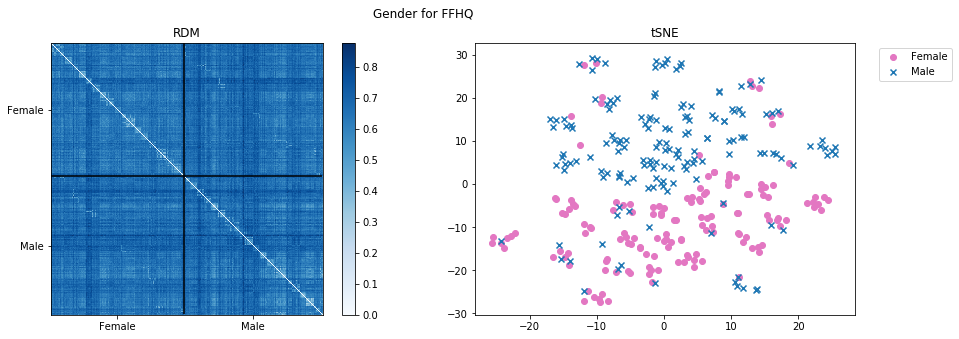

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Gender for FFHQ')

im = ax1.imshow(rdm_gender_ffhq, cmap='Blues')
ax1.set_title('RDM')
fig.colorbar(im, ax=ax1)
add_ticks_labels_lines(ax1, gender_ticks, gender_labels, gender_lines)

ax2.set_title('tSNE')
scatter_gender(ax2, tsne.fit_transform(rdm_gender_ffhq))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

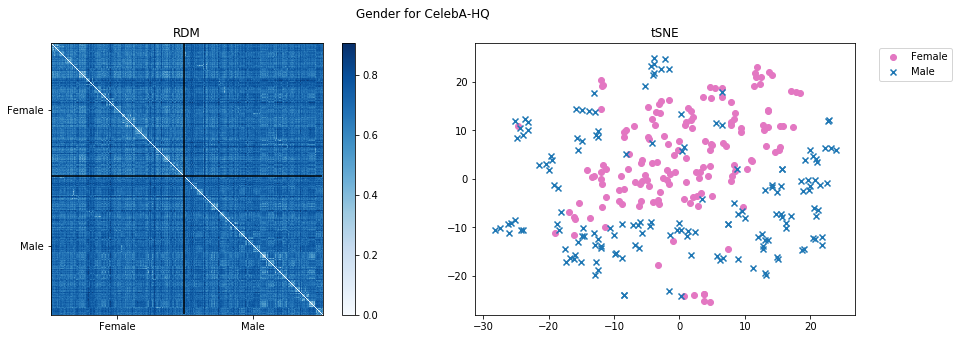

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Gender for CelebA-HQ')

im = ax1.imshow(rdm_gender_clba, cmap='Blues')
ax1.set_title('RDM')
fig.colorbar(im, ax=ax1)
add_ticks_labels_lines(ax1, gender_ticks, gender_labels, gender_lines)

ax2.set_title('tSNE')
scatter_gender(ax2, tsne.fit_transform(rdm_gender_clba))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Significance testing

In [0]:
# Collect random rho values by shuffeling one of the rdms while keeping the other unchanged

# rhos_gender_ffhq = get_random_rhos( hyp_vector_gender, rdm_gender_ffhq, 1000 )
# np.save('rhos/rhos_gender_ffhq.npy', np.asarray(rhos_gender_ffhq))

# rhos_gender_clba = get_random_rhos( hyp_vector_gender, rdm_gender_clba, 1000 )
# np.save('rhos/rhos_gender_clba.npy', np.asarray(rhos_gender_clba))

In [0]:
# Get rho values
rho_gender_ffhq, pval = spearmanr(hyp_vector_gender, make_significance_vector(rdm_gender_ffhq))
rho_gender_clba, pval = spearmanr(hyp_vector_gender, make_significance_vector(rdm_gender_clba))

# Get random rho values
rhos_gender_ffhq = np.load('rhos/rhos_gender_ffhq.npy')
rhos_gender_clba = np.load('rhos/rhos_gender_clba.npy')
# Get 95th percentile
perc_gender_ffhq = np.percentile(rhos_gender_ffhq, 95)
perc_gender_clba = np.percentile(rhos_gender_clba, 95)

In [29]:
print('Significance testing for gender')

print('\nFFHQ')
print('rho =', rho_gender_ffhq)
print('95th percentile =', perc_gender_ffhq)
print('significant =', rho_gender_ffhq > perc_gender_ffhq)

print('\nCelebA')
print('rho =', rho_gender_clba)
print('95th percentile =', perc_gender_clba)
print('significant =', rho_gender_clba > perc_gender_clba)

Significance testing for gender

FFHQ
rho = 0.10883863584925457
95th percentile = 0.006024101917946276
significant = True

CelebA
rho = 0.12291194538884267
95th percentile = 0.006279696340328716
significant = True


### Emotion

In [0]:
# Make RDMs using cosine distance
rdm_emotion_ffhq = squareform( pdist(emotion_space_ffhq, 'cosine') )
rdm_emotion_clba = squareform( pdist(emotion_space_clba, 'cosine') )

Visualisation

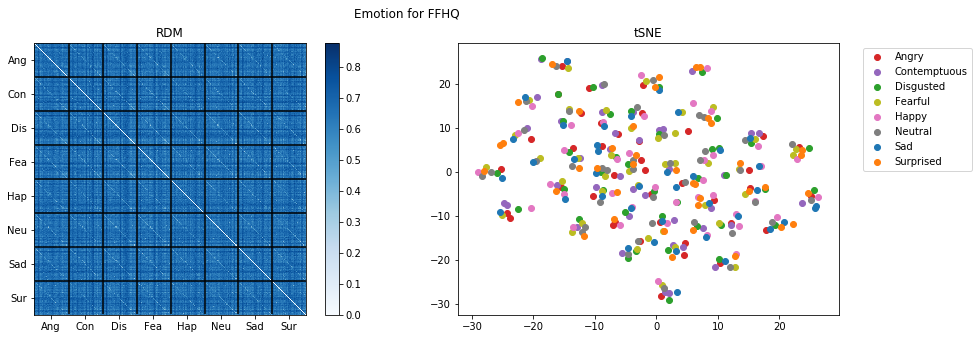

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Emotion for FFHQ')

im = ax1.imshow(rdm_emotion_ffhq, cmap='Blues')
ax1.set_title('RDM')
fig.colorbar(im, ax=ax1)
add_ticks_labels_lines(ax1, emotion_ticks, emotion_labels_short, emotion_lines)

ax2.set_title('tSNE')
scatter_emotion(ax2, tsne.fit_transform(rdm_emotion_ffhq))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

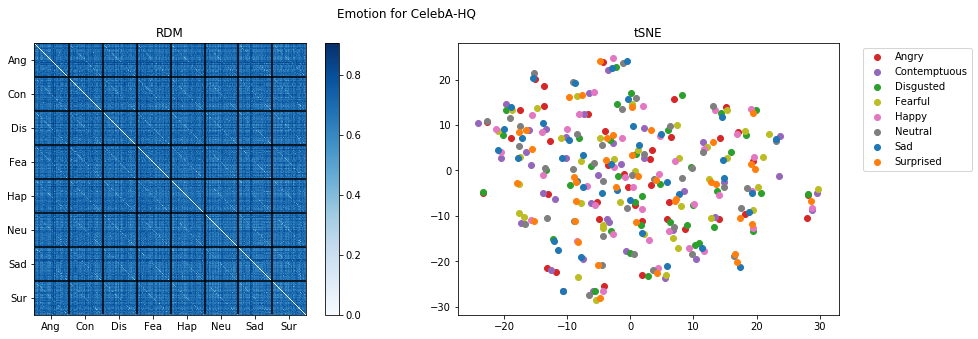

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Emotion for CelebA-HQ')

im = ax1.imshow(rdm_emotion_clba, cmap='Blues')
ax1.set_title('RDM')
fig.colorbar(im, ax=ax1)
add_ticks_labels_lines(ax1, emotion_ticks, emotion_labels_short, emotion_lines)

ax2.set_title('tSNE')
scatter_emotion(ax2, tsne.fit_transform(rdm_emotion_clba))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Significance testing

In [0]:
# Collect random rho values by shuffeling one of the rdms while keeping the other unchanged

# rhos_emotion_ffhq = get_random_rhos( hyp_vector_emotion, rdm_emotion_ffhq, 1000 )
# np.save('rhos/rhos_emotion_ffhq.npy', np.asarray(rhos_emotion_ffhq))

# rhos_emotion_clba = get_random_rhos( hyp_vector_emotion, rdm_emotion_clba, 1000 )
# np.save('rhos/rhos_emotion_clba.npy', np.asarray(rhos_emotion_clba))

In [0]:
# Get rho values
rho_emotion_ffhq, pval = spearmanr(hyp_vector_emotion, make_significance_vector(rdm_emotion_ffhq))
rho_emotion_clba, pval = spearmanr(hyp_vector_emotion, make_significance_vector(rdm_emotion_clba))

# Get random rho values
rhos_emotion_ffhq = np.load('rhos/rhos_emotion_ffhq.npy')
rhos_emotion_clba = np.load('rhos/rhos_emotion_clba.npy')
# Get 95th percentile
perc_emotion_ffhq = np.percentile(rhos_emotion_ffhq, 95)
perc_emotion_clba = np.percentile(rhos_emotion_clba, 95)

In [35]:
print('Significance testing for gender')

print('\nFFHQ')
print('rho =', rho_emotion_ffhq)
print('95th percentile =', perc_emotion_ffhq)
print('significant =', rho_emotion_ffhq > perc_emotion_ffhq)

print('\nCelebA')
print('rho =', rho_emotion_clba)
print('95th percentile =', perc_emotion_clba)
print('significant =', rho_emotion_clba > perc_emotion_clba)

Significance testing for gender

FFHQ
rho = -0.0051180280325016985
95th percentile = 0.005088790863046086
significant = False

CelebA
rho = 0.0012367221121205563
95th percentile = 0.0050925035908140955
significant = False


#### Emotion vectors

For all identities a base vector is subtracted from the emotions to find the emotion directions. \\

```
Indices of emotions for one identity:
0 = angry 
1 = contemptuous 
2 = disgusted 
3 = fearful 
4 = happy 
5 = neutral 
6 = sad 
7 = surprised
```










In [0]:
emotion_vector_cols = ['tab:red', 'tab:purple', 'tab:green', 'tab:olive', 'tab:pink', 'tab:blue', 'tab:orange']
emotion_vector_labels = ['Angry', 'Contemptuous', 'Disgusted', 'Fearful', 'Happy', 'Sad', 'Surprised']
emotion_vector_labels_short = [l[:3] for l in emotion_vector_labels]

emotion_vector_ticks  = [19 + 39*i for i in range(7)]
emotion_vector_lines  = [39*i for i in range(1,7)]

origin = [0], [0] # origin point

In [0]:
def add_ticks_rdm_emotion_vectors( ax, ticks, labels, lines ):
  ax.set_xticks(ticks)
  ax.set_xticklabels(labels)
  ax.set_yticks(ticks)
  ax.set_yticklabels(labels)
  ax.vlines(lines, 0, 272)
  ax.hlines(lines, 0, 272)

In [0]:
def get_space_without_neutral( original_space ):
  # 312 - 39 (all neutrals) = 273
  direction_space = np.zeros((273, 18*512)) # (273, 9216)
  for i in identities:
    x = i*7
    y = i*8
    neutral = original_space[y+5]  # 5th index is neutral vector        
    direction_space[x]   = original_space[y]   - neutral  # angry
    direction_space[x+1] = original_space[y+1] - neutral  # contemptuous
    direction_space[x+2] = original_space[y+2] - neutral  # disgusted
    direction_space[x+3] = original_space[y+3] - neutral  # fearful
    direction_space[x+4] = original_space[y+4] - neutral  # happy
    direction_space[x+5] = original_space[y+6] - neutral  # sad
    direction_space[x+6] = original_space[y+7] - neutral  # surprised
  return direction_space

def get_space_without_average( original_space ):
  direction_space = np.zeros((273, 18*512)) # (273, 9216)
  for i in range(39):
    x = i*7
    y = i*8
    average = np.average( original_space[x:x+7], axis=0 )
    direction_space[x]   = original_space[y]   - average  # angry
    direction_space[x+1] = original_space[y+1] - average  # contemptuous
    direction_space[x+2] = original_space[y+2] - average  # disgusted
    direction_space[x+3] = original_space[y+3] - average  # fearful
    direction_space[x+4] = original_space[y+4] - average  # happy
    direction_space[x+5] = original_space[y+6] - average  # sad
    direction_space[x+6] = original_space[y+7] - average  # surprised
  return direction_space

def get_sorted_emotion_space( direction_space ):
  direction_space_sorted = np.zeros((273, 18*512)) # (273, 9216)
  count = 0
  for i in range(7):
    for j in identities:
      direction_space_sorted[count] = direction_space[i + 7*j]
      count+=1
  return direction_space_sorted

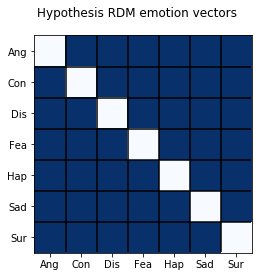

In [48]:
# Make hypothesis RDM and vector for significance testing
hyp_rdm_emotion_vectors = np.ones((273, 273))
for i in range(0, 273, 39):
  hyp_rdm_emotion_vectors[i:i+39, i:i+39] = np.zeros((39,39))
hyp_vector_emotion_vectors = make_significance_vector(hyp_rdm_emotion_vectors)

fig, ax = plt.subplots(1,1)
fig.suptitle('Hypothesis RDM emotion vectors')
ax.imshow(hyp_rdm_emotion_vectors, cmap='Blues')
add_ticks_rdm_emotion_vectors(ax, emotion_vector_ticks, emotion_vector_labels_short, emotion_vector_lines)
plt.show()

##### Neutral as base

In [0]:
# Spaces
space_without_neutral_ffhq = get_space_without_neutral(identity_space_ffhq)
space_without_neutral_sorted_ffhq = get_sorted_emotion_space(space_without_neutral_ffhq)
space_without_neutral_clba = get_space_without_neutral(identity_space_clba)
space_without_neutral_sorted_clba = get_sorted_emotion_space(space_without_neutral_clba)

# RDMs
rdm_emotion_without_neutral_ffhq = squareform(pdist(space_without_neutral_sorted_ffhq, 'cosine'))
rdm_emotion_without_neutral_clba = squareform(pdist(space_without_neutral_sorted_clba, 'cosine'))

# Vectors for significance testing
vector_emotion_without_neutral_ffhq = make_significance_vector(rdm_emotion_without_neutral_ffhq)
vector_emotion_without_neutral_clba = make_significance_vector(rdm_emotion_without_neutral_clba)

FFHQ

In [0]:
V_neutral_ffhq = tsne.fit_transform(rdm_emotion_without_neutral_ffhq)
x_neutral_ffhq, y_neutral_ffhq = V_neutral_ffhq[:, 0], V_neutral_ffhq[:, 1]

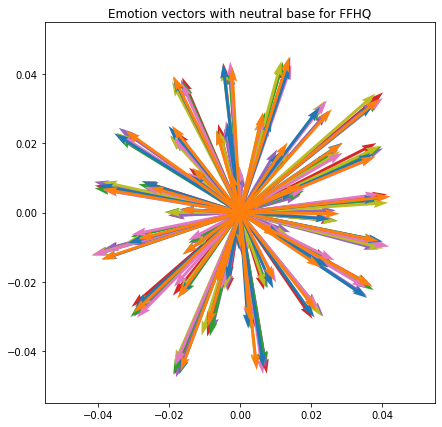

In [51]:
plt.figure(figsize=(7,7))
plt.title('Emotion vectors with neutral base for FFHQ')

for i in range(7):
  j = i*39
  Q = plt.quiver(*origin, x_neutral_ffhq[ j:j+39 ] , y_neutral_ffhq[ j:j+39 ], color=emotion_vector_cols[i], scale=40 )

plt.show()

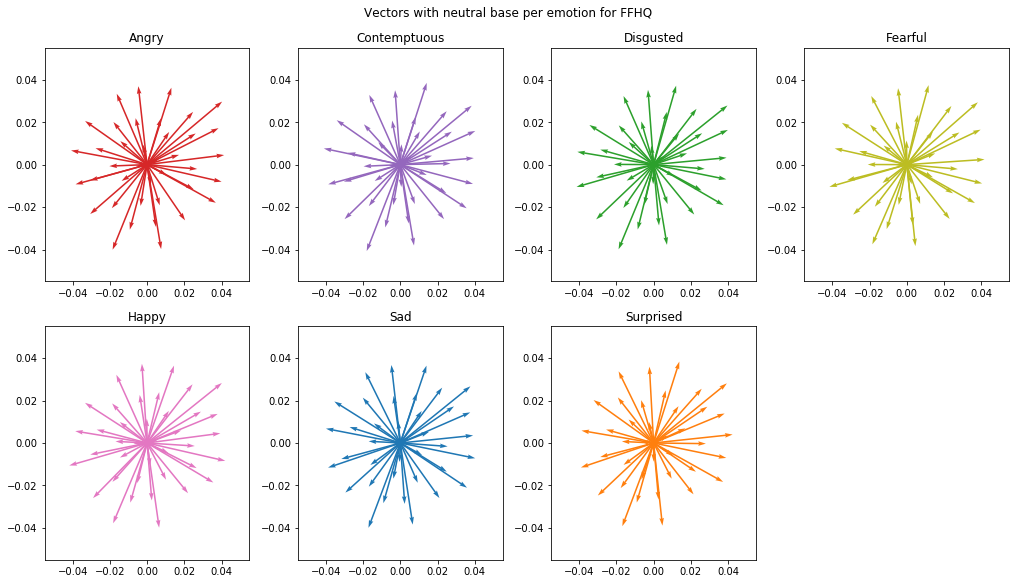

In [52]:
fig, ax = plt.subplots(2, 4, figsize=(14,8), constrained_layout=True)
fig.suptitle('Vectors with neutral base per emotion for FFHQ')

for i in range(7):
  j = i*39
  r = 0 if i<4 else 1
  c = i if i<4 else i-4
  ax[r][c].quiver(*origin, x_neutral_ffhq[ j:j+39 ] , y_neutral_ffhq[ j:j+39 ], color=emotion_vector_cols[i], scale=40 )
  ax[r][c].set_title(emotion_vector_labels[i])
  
fig.delaxes(ax[1][3])
plt.show()

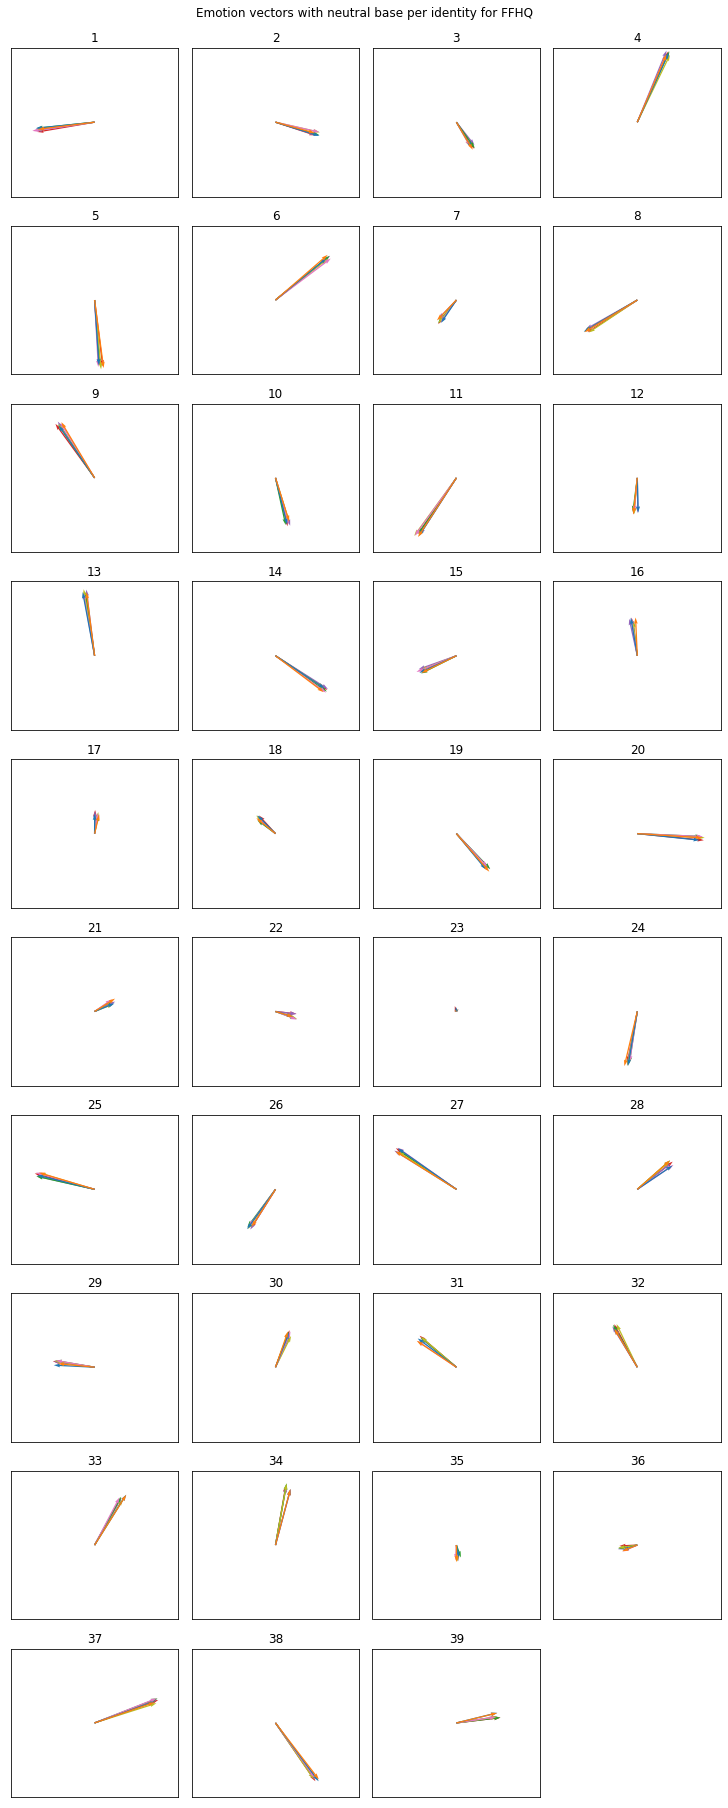

In [53]:
rdm = squareform( pdist(space_without_neutral_ffhq, 'cosine') )
V = tsne.fit_transform( rdm )
x, y = V[:, 0], V[:, 1]

fig, ax = plt.subplots(10, 4, figsize=(10, 25), constrained_layout=True)
fig.suptitle('Emotion vectors with neutral base per identity for FFHQ')

row, col = 0, 0
for i in range(39):
  j = i*7
  for k in range(7):
    ax[row][col].quiver(*origin, x[j+k] , y[j+k], color=emotion_vector_cols[k], scale=40 )
  ax[row][col].set_title(identity_labels[i])
  ax[row][col].yaxis.set_visible(False)
  ax[row][col].xaxis.set_visible(False)
  if (col >= 3):
    col = 0
    row += 1
  else:
    col += 1

fig.delaxes(ax[9][3])
plt.show()

CelebA-HQ

In [0]:
V_neutral_clba = tsne.fit_transform(rdm_emotion_without_neutral_clba)
x_neutral_clba, y_neutral_clba = V_neutral_clba[:, 0], V_neutral_clba[:, 1]

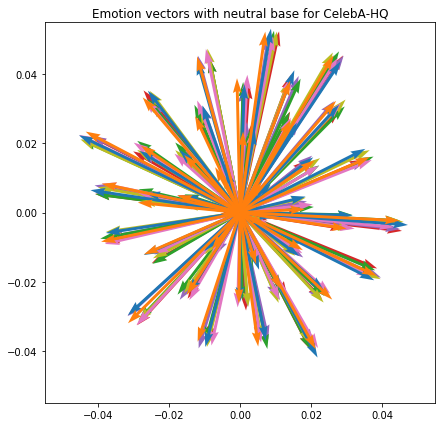

In [55]:
plt.figure(figsize=(7,7))
plt.title('Emotion vectors with neutral base for CelebA-HQ')
for i in range(7):
  j = i*39
  Q = plt.quiver(*origin, x_neutral_clba[ j:j+39 ] , y_neutral_clba[ j:j+39 ], color=emotion_vector_cols[i], scale=40 )

plt.show()

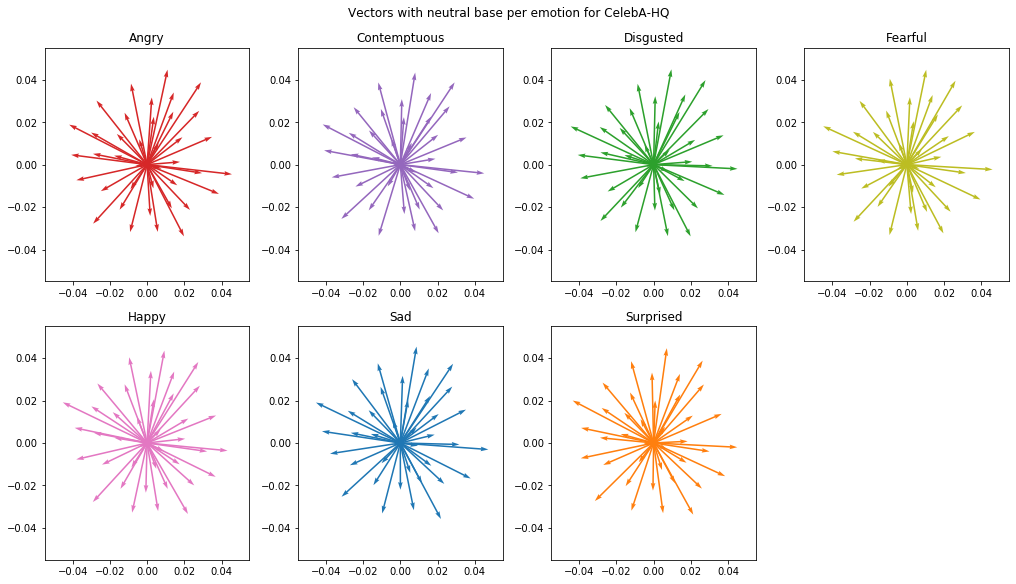

In [56]:
fig, ax = plt.subplots(2, 4, figsize=(14,8), constrained_layout=True)
fig.suptitle('Vectors with neutral base per emotion for CelebA-HQ')

for i in range(7):
  j = i*39
  r = 0 if i<4 else 1
  c = i if i<4 else i-4
  ax[r][c].quiver(*origin, x_neutral_clba[ j:j+39 ] , y_neutral_clba[ j:j+39 ], color=emotion_vector_cols[i], scale=40 )
  ax[r][c].set_title(emotion_vector_labels[i])
  
fig.delaxes(ax[1][3])
plt.show()

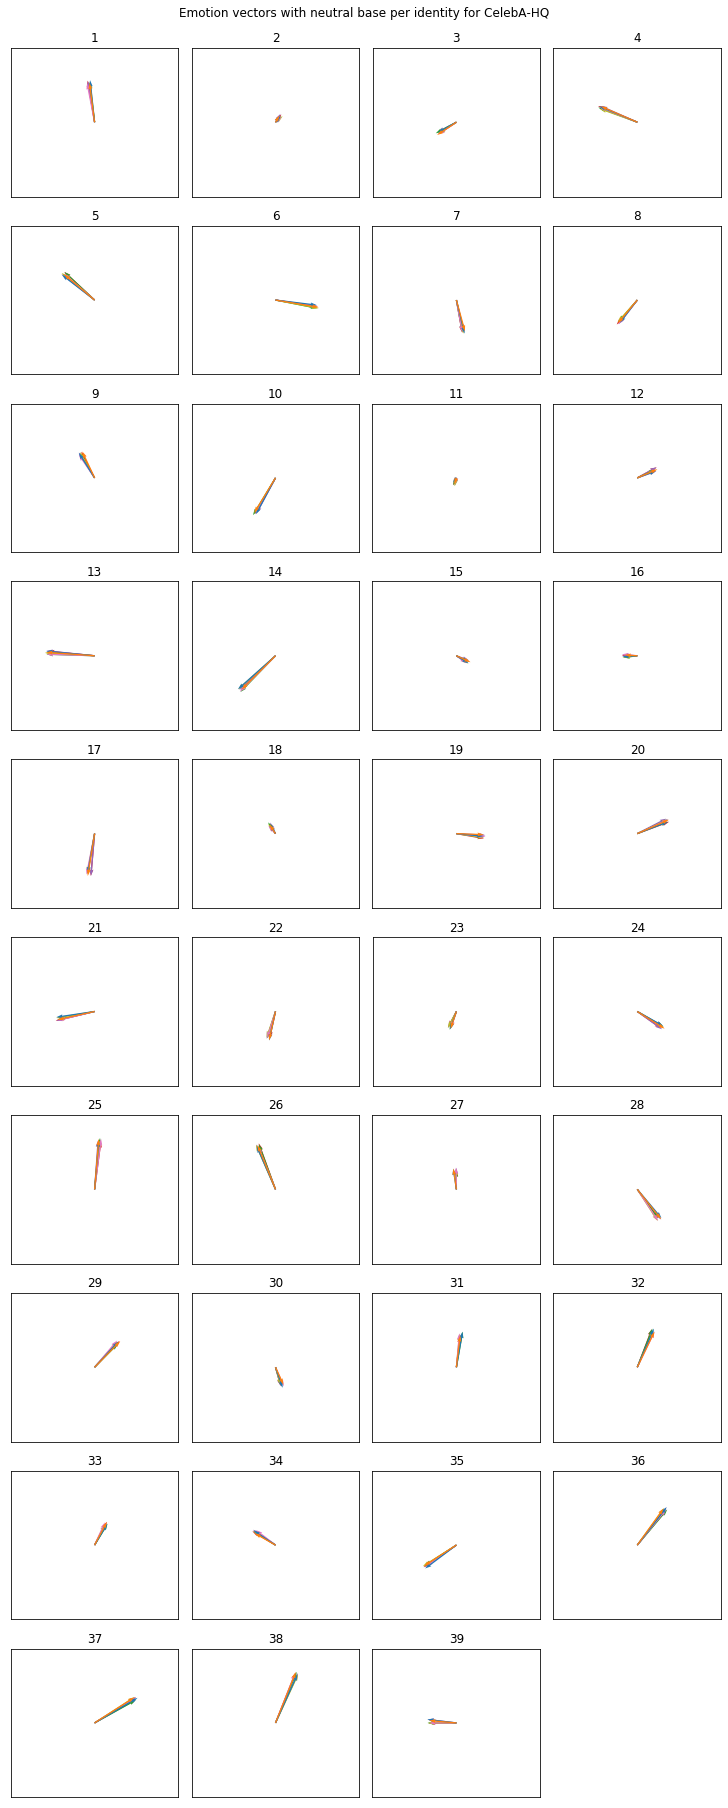

In [57]:
rdm = squareform( pdist(space_without_neutral_clba, 'cosine') )
V = tsne.fit_transform( rdm )
x, y = V[:, 0], V[:, 1]

fig, ax = plt.subplots(10, 4, figsize=(10, 25), constrained_layout=True)
fig.suptitle('Emotion vectors with neutral base per identity for CelebA-HQ')

row, col = 0, 0
for i in range(39):
  j = i*7
  for k in range(7):
    ax[row][col].quiver(*origin, x[j+k] , y[j+k], color=emotion_vector_cols[k], scale=60 )
  ax[row][col].set_title(identity_labels[i])
  ax[row][col].yaxis.set_visible(False)
  ax[row][col].xaxis.set_visible(False)
  if (col >= 3):
    col = 0
    row += 1
  else:
    col += 1

fig.delaxes(ax[9][3])
plt.show()

Significance

In [0]:
# Collect random rho values by shuffeling one of the rdms while keeping the other unchanged

# rhos_emotion_without_neutral_ffhq = get_random_rhos( hyp_vector_emotion_vectors, rdm_emotion_without_neutral_ffhq, 1000 )
# np.save('rhos/rhos_emotion_without_neutral_ffhq.npy', np.asarray(rhos_emotion_without_neutral_ffhq))

# rhos_emotion_without_neutral_clba = get_random_rhos( hyp_vector_emotion_vectors, rdm_emotion_without_neutral_clba, 1000 )
# np.save('rhos/rhos_emotion_without_neutral_clba.npy', np.asarray(rhos_emotion_without_neutral_clba))

In [0]:
 # Get rho values
rho_emotion_without_neutral_ffhq, pval = spearmanr(hyp_vector_emotion_vectors, make_significance_vector(rdm_emotion_without_neutral_ffhq))
rho_emotion_without_neutral_clba, pval = spearmanr(hyp_vector_emotion_vectors, make_significance_vector(rdm_emotion_without_neutral_clba))

# Get random rho values
rhos_emotion_without_neutral_ffhq = np.load('rhos/rhos_emotion_without_neutral_ffhq.npy')
rhos_emotion_without_neutral_clba = np.load('rhos/rhos_emotion_without_neutral_clba.npy')
# Get 95th percentile
perc_emotion_without_neutral_ffhq = np.percentile(rhos_emotion_without_neutral_ffhq, 95)
perc_emotion_without_neutral_clba = np.percentile(rhos_emotion_without_neutral_clba, 95)

In [60]:
print('Significance testing for gender')

print('\nFFHQ')
print('rho =', rho_emotion_without_neutral_ffhq)
print('95th percentile =', perc_emotion_without_neutral_ffhq)
print('significant =', rho_emotion_without_neutral_ffhq > perc_emotion_without_neutral_ffhq)

print('\nCelebA')
print('rho =', rho_emotion_without_neutral_clba)
print('95th percentile =', perc_emotion_without_neutral_clba)
print('significant =', rho_emotion_without_neutral_clba > perc_emotion_without_neutral_clba)

Significance testing for gender

FFHQ
rho = -0.009622540484223162
95th percentile = 0.008308794680191637
significant = False

CelebA
rho = -0.007698475279443765
95th percentile = 0.009784274735806802
significant = False


##### Average as base

In [0]:
# Spaces
space_without_average_ffhq = get_space_without_average(identity_space_ffhq)
space_without_average_sorted_ffhq = get_sorted_emotion_space(space_without_average_ffhq)
space_without_average_clba = get_space_without_average(identity_space_clba)
space_without_average_sorted_clba = get_sorted_emotion_space(space_without_average_clba)

# RDMs
rdm_emotion_without_average_ffhq = squareform(pdist(space_without_average_sorted_ffhq, 'cosine'))
rdm_emotion_without_average_clba = squareform(pdist(space_without_average_sorted_clba, 'cosine'))

# Vectors for significance testing
vector_emotion_without_average_ffhq = make_significance_vector(rdm_emotion_without_average_ffhq)
vector_emotion_without_average_clba = make_significance_vector(rdm_emotion_without_average_clba)

FFHQ

In [0]:
V_average_ffhq = tsne.fit_transform(rdm_emotion_without_average_ffhq)
x_average_ffhq, y_average_ffhq = V_average_ffhq[:, 0], V_average_ffhq[:, 1]

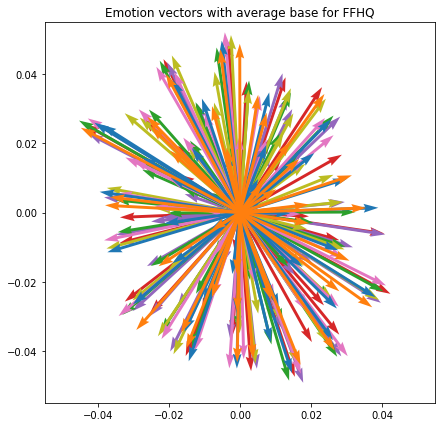

In [63]:
plt.figure(figsize=(7,7))
plt.title('Emotion vectors with average base for FFHQ')

for i in range(7):
  j = i*39
  Q = plt.quiver(*origin, x_average_ffhq[ j:j+39 ] , y_average_ffhq[ j:j+39 ], color=emotion_vector_cols[i], scale=50 )

plt.show()

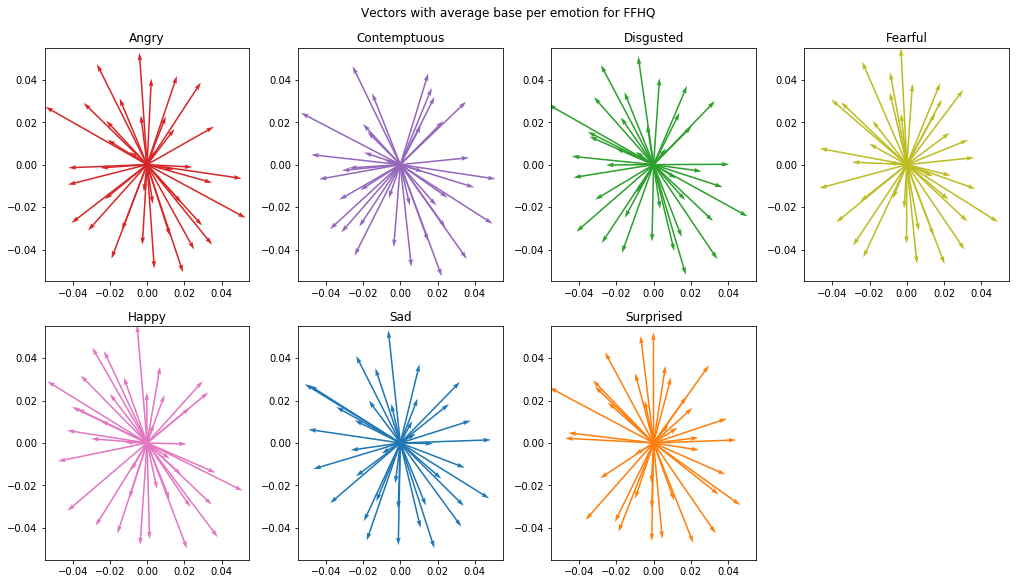

In [64]:
fig, ax = plt.subplots(2, 4, figsize=(14,8), constrained_layout=True)
fig.suptitle('Vectors with average base per emotion for FFHQ')

for i in range(7):
  j = i*39
  r = 0 if i<4 else 1
  c = i if i<4 else i-4
  ax[r][c].quiver(*origin, x_average_ffhq[ j:j+39 ] , y_average_ffhq[ j:j+39 ], color=emotion_vector_cols[i], scale=40 )
  ax[r][c].set_title(emotion_vector_labels[i])
  
fig.delaxes(ax[1][3])
plt.show()

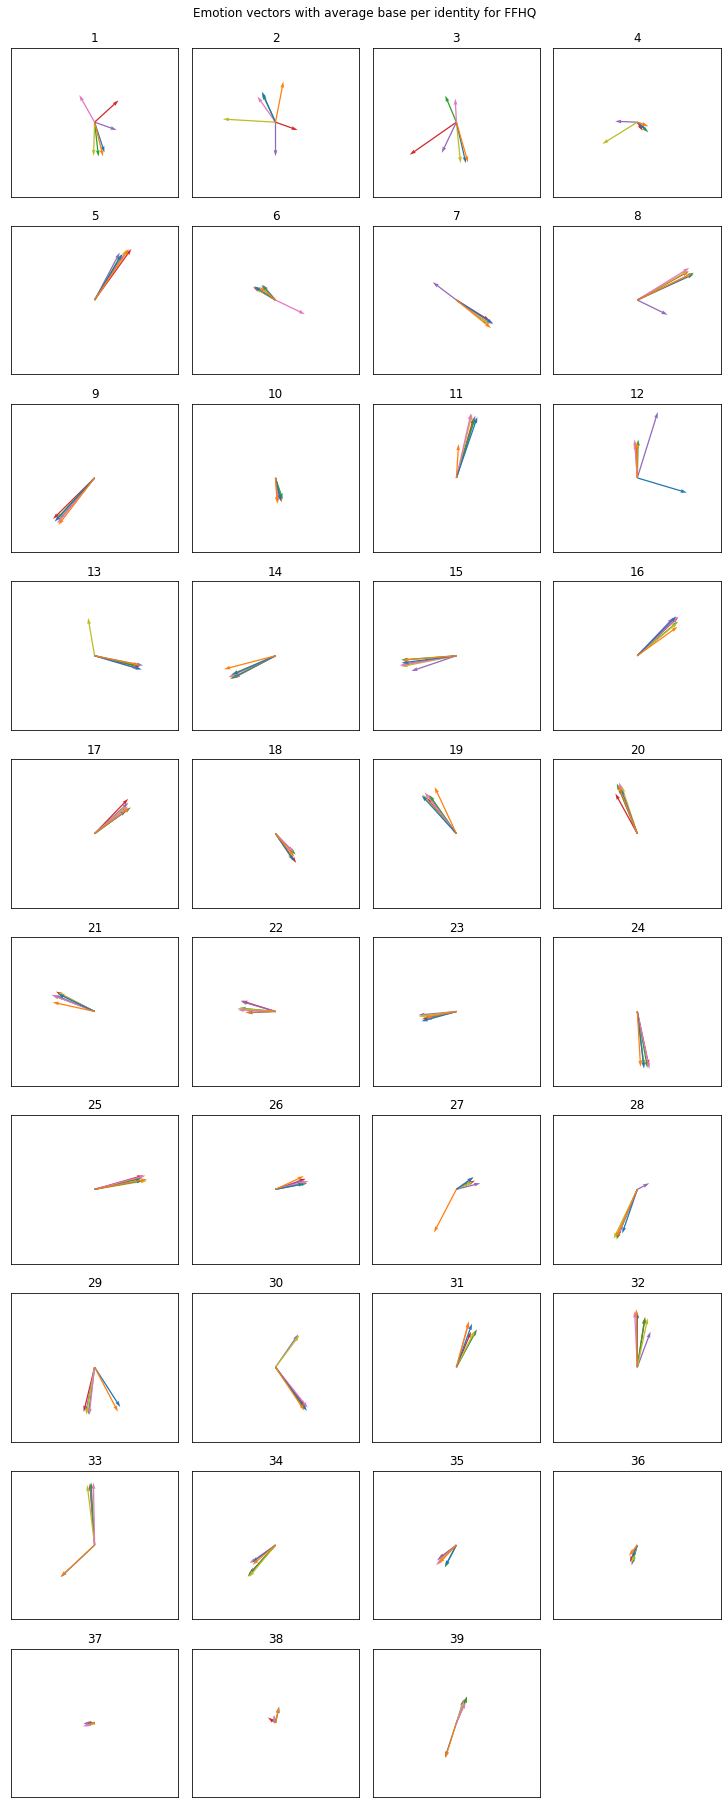

In [66]:
rdm = squareform( pdist(space_without_average_ffhq, 'cosine') )
V = tsne.fit_transform( rdm )
x, y = V[:, 0], V[:, 1]

fig, ax = plt.subplots(10, 4, figsize=(10, 25), constrained_layout=True)
fig.suptitle('Emotion vectors with average base per identity for FFHQ')

row, col = 0, 0
for i in range(39):
  j = i*7
  for k in range(7):
    ax[row][col].quiver(*origin, x[j+k] , y[j+k], color=emotion_vector_cols[k], scale=60 )
  ax[row][col].set_title(identity_labels[i])
  ax[row][col].yaxis.set_visible(False)
  ax[row][col].xaxis.set_visible(False)
  if (col >= 3):
    col = 0
    row += 1
  else:
    col += 1

fig.delaxes(ax[9][3])
plt.show()

CelebA-HQ

In [0]:
V_average_clba = tsne.fit_transform(rdm_emotion_without_average_clba)
x_average_clba, y_average_clba = V_average_clba[:, 0], V_average_clba[:, 1]

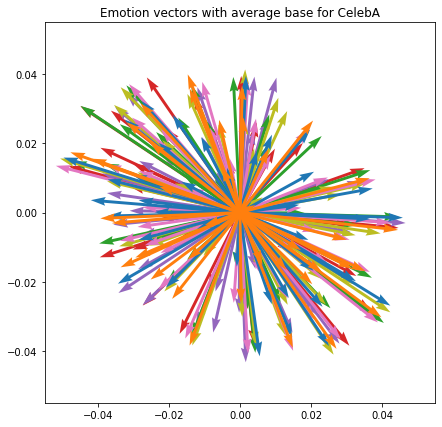

In [68]:
plt.figure(figsize=(7,7))
plt.title('Emotion vectors with average base for CelebA')

for i in range(7):
  j = i*39
  Q = plt.quiver(*origin, x_average_clba[ j:j+39 ] , y_average_clba[ j:j+39 ], color=emotion_vector_cols[i], scale=50 )

plt.show()

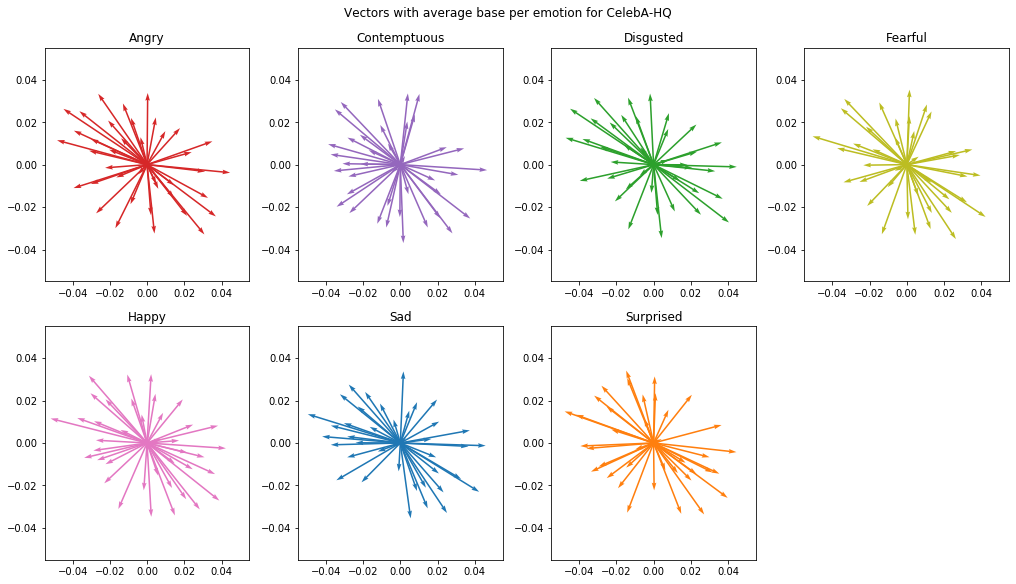

In [69]:
fig, ax = plt.subplots(2, 4, figsize=(14,8), constrained_layout=True)
fig.suptitle('Vectors with average base per emotion for CelebA-HQ')

for i in range(7):
  j = i*39
  r = 0 if i<4 else 1
  c = i if i<4 else i-4
  ax[r][c].quiver(*origin, x_average_clba[ j:j+39 ] , y_average_clba[ j:j+39 ], color=emotion_vector_cols[i], scale=50 )
  ax[r][c].set_title(emotion_vector_labels[i])
  
fig.delaxes(ax[1][3])
plt.show()

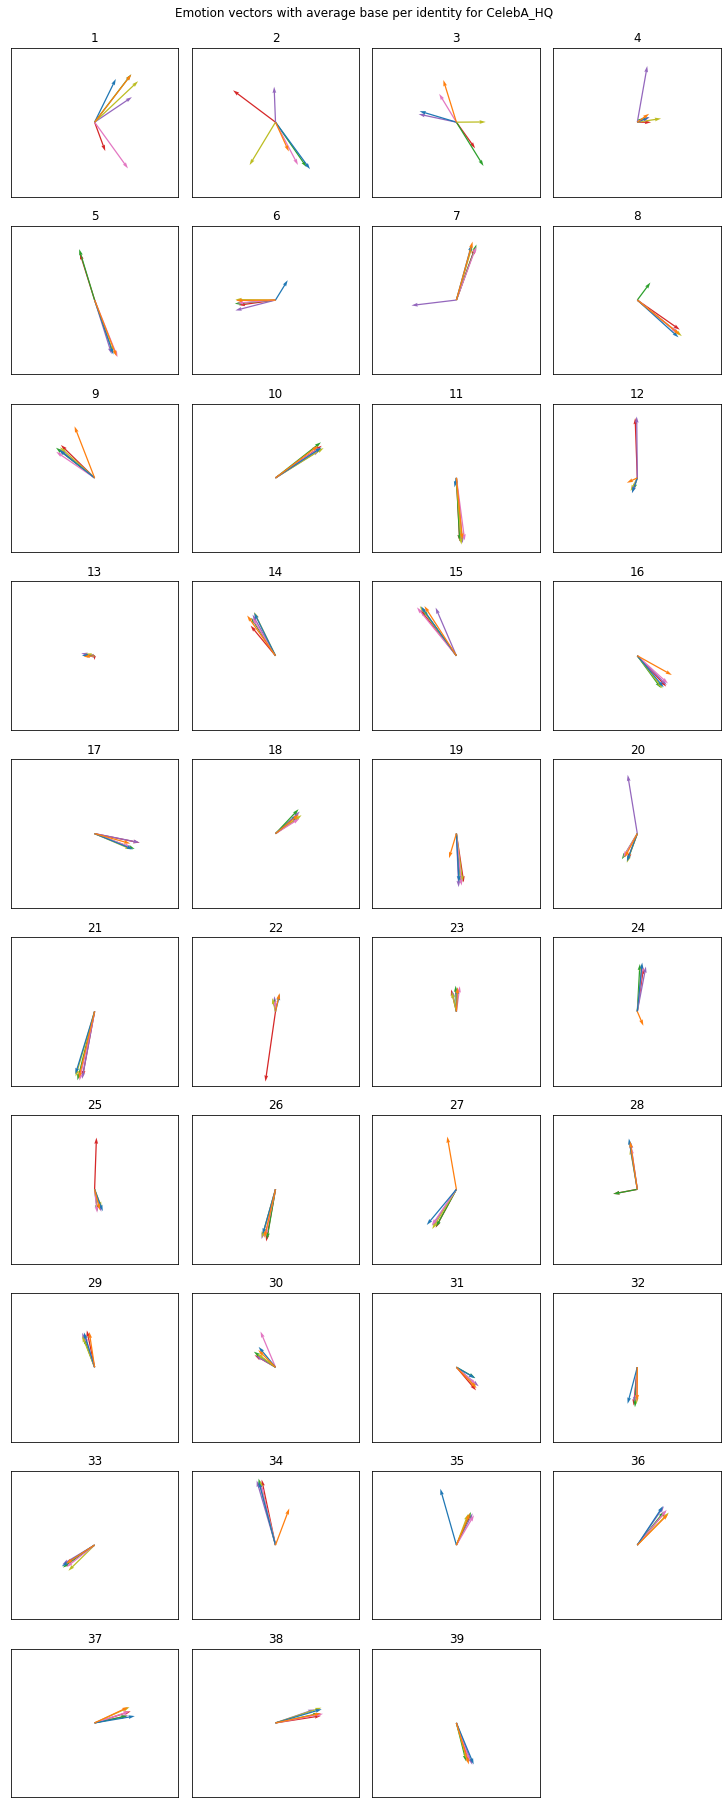

In [70]:
rdm = squareform( pdist(space_without_average_clba, 'cosine') )
V = tsne.fit_transform( rdm )
x, y = V[:, 0], V[:, 1]

fig, ax = plt.subplots(10, 4, figsize=(10, 25), constrained_layout=True)
fig.suptitle('Emotion vectors with average base per identity for CelebA_HQ')

row, col = 0, 0
for i in range(39):
  j = i*7
  for k in range(7):
    ax[row][col].quiver(*origin, x[j+k] , y[j+k], color=emotion_vector_cols[k], scale=60 )
  ax[row][col].set_title(identity_labels[i])
  ax[row][col].yaxis.set_visible(False)
  ax[row][col].xaxis.set_visible(False)
  if (col >= 3):
    col = 0
    row += 1
  else:
    col += 1

fig.delaxes(ax[9][3])
plt.show()

In [0]:
# Collect random rho values by shuffeling one of the rdms while keeping the other unchanged

# rhos_emotion_without_average_ffhq = get_random_rhos( hyp_vector_emotion_vectors, rdm_emotion_without_average_ffhq, 1000 )
# np.save('rhos/rhos_emotion_without_average_ffhq.npy', np.asarray(rhos_emotion_without_average_ffhq))

# rhos_emotion_without_average_clba = get_random_rhos( hyp_vector_emotion_vectors, rdm_emotion_without_average_clba, 1000 )
# np.save('rhos/rhos_emotion_without_average_clba.npy', np.asarray(rhos_emotion_without_average_clba))

In [0]:
 # Get rho values
rho_emotion_without_average_ffhq, pval = spearmanr(hyp_vector_emotion_vectors, make_significance_vector(rdm_emotion_without_average_ffhq))
rho_emotion_without_average_clba, pval = spearmanr(hyp_vector_emotion_vectors, make_significance_vector(rdm_emotion_without_average_clba))

# Get random rho values
rhos_emotion_without_average_ffhq = np.load('rhos/rhos_emotion_without_average_ffhq.npy')
rhos_emotion_without_average_clba = np.load('rhos/rhos_emotion_without_average_clba.npy')
# Get 95th percentile
perc_emotion_without_average_ffhq = np.percentile(rhos_emotion_without_average_ffhq, 95)
perc_emotion_without_average_clba = np.percentile(rhos_emotion_without_average_clba, 95)

In [73]:
print('Significance testing for gender')

print('\nFFHQ')
print('rho =', rho_emotion_without_average_ffhq)
print('95th percentile =', perc_emotion_without_average_ffhq)
print('significant =', rho_emotion_without_average_ffhq > perc_emotion_without_average_ffhq)

print('\nCelebA')
print('rho =', rho_emotion_without_average_clba)
print('95th percentile =', perc_emotion_without_average_clba)
print('significant =', rho_emotion_without_average_clba > perc_emotion_without_average_clba)

Significance testing for gender

FFHQ
rho = -0.008768273451945714
95th percentile = 0.009090178422895794
significant = False

CelebA
rho = -0.003220394332710346
95th percentile = 0.008682344417783087
significant = False


## Comparison

Significance testing

In [0]:
# Collect random rho values by shuffeling one of the rdms while keeping the other unchanged
# rhos = get_random_rhos( vector_identity_ffhq, rdm_identity_clba, 1000 )
# np.save('rhos/rhos.npy', np.asarray(rhos))

In [0]:
# Get rho value
rho, pval = spearmanr(make_significance_vector(rdm_identity_ffhq), make_significance_vector(rdm_identity_clba))
rhos = np.load('rhos/rhos.npy')
perc = np.percentile(rhos, 95)

In [77]:
print('Significance testing for difference between styleGAN trained on FFHQ and CelebA')
print('rho =', rho)
print('95th percentile =', perc)
print('significant =', rho > perc)

Significance testing for difference between styleGAN trained on FFHQ and CelebA
rho = 0.26028124395594343
95th percentile = 0.05028961452391236
significant = True
